In [2]:
%pip install scipy
%pip install scikit-learn


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid")

# Läs in data – ändra filnamn om det behövs
df = pd.read_csv("dataset.csv", delimiter=";")

print(df.shape)
df.head()


(50000, 19)


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2020-02-11 00:00,"2,020.0000","1,930,438,491.0000",2020-01-26,20200125,20200126,"20,200,210.0000",USD,RV,1.0000,NaN,"54,273.2800","20,200,126.0000",NAH4,"1,930,438,491.0000",0
1,U001,200980828,BEN E,2019-08-08 00:00,"2,019.0000","1,929,646,410.0000",2019-07-22,20190722,20190722,"20,190,811.0000",USD,RV,1.0000,NaN,"79,656.6000","20,190,722.0000",NAD1,"1,929,646,410.0000",0
2,U001,200792734,MDV/ trust,2019-12-30 00:00,"2,019.0000","1,929,873,765.0000",2019-09-14,20190914,20190914,"20,190,929.0000",USD,RV,1.0000,NaN,"2,253.8600","20,190,914.0000",NAA8,"1,929,873,765.0000",0
3,CA02,140105686,SYSC llc,NaN,"2,020.0000","2,960,623,488.0000",2020-03-30,20200330,20200330,"20,200,410.0000",CAD,RV,1.0000,NaN,"3,299.7000","20,200,331.0000",CA10,"2,960,623,488.0000",1
4,U001,200769623,WAL-MAR foundation,2019-11-25 00:00,"2,019.0000","1,930,147,974.0000",2019-11-13,20191113,20191113,"20,191,128.0000",USD,RV,1.0000,NaN,"33,133.2900","20,191,113.0000",NAH4,"1,930,147,974.0000",0


In [4]:
# Hjälpfunktion för datum i formatet ÅÅÅÅMMDD eller ÅÅÅÅMMDD.0
def fix_date(col):
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(8)
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

# Kolumner som hade YYYYMMDD
raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date",
]

for col in raw_yyyymmdd_cols:
    if col in df.columns:
        df[col] = fix_date(df[col])

# Kolumner som redan är riktiga datumsträngar
for col in ["posting_date", "clear_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[raw_yyyymmdd_cols + ["posting_date", "clear_date"]].head()


,document_create_date,document_create_date.1,due_in_date,baseline_create_date,posting_date,clear_date
0,2020-01-25,2020-01-26,2020-02-10,2020-01-26,2020-01-26,2020-02-11
1,2019-07-22,2019-07-22,2019-08-11,2019-07-22,2019-07-22,2019-08-08
2,2019-09-14,2019-09-14,2019-09-29,2019-09-14,2019-09-14,2019-12-30
3,2020-03-30,2020-03-30,2020-04-10,2020-03-31,2020-03-30,NaT
4,2019-11-13,2019-11-13,2019-11-28,2019-11-13,2019-11-13,2019-11-25


In [5]:
# Hämta alla unika kundnummer
unique_customers_number = df["cust_number"].unique()

# Sortera för stabil ordning (valfritt, men bra för reproducerbarhet)
unique_customers = sorted(unique_customers_number)

# Skapa mapping: riktig kund → artificiellt ID
mapping = {
    cust: 100000 + i
    for i, cust in enumerate(unique_customers)
}

# Lägg till kolumnen
df["customer_alt_id"] = df["cust_number"].map(mapping)

# Lika många kundnamnnamn som kundnummer?
print(f"Unika nummer: {df["customer_alt_id"].nunique()}")
print(f"Unika namn: {df["name_customer"].nunique()}")

# 1. Normalisera namn
df["name_normalized"] = (
    df["name_customer"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)   # ta bort specialtecken
    .str.replace(r"\s+", " ", regex=True)         # collapsa multipla mellanslag
    .str.strip()
)

# 2. Räkna hur ofta varje normaliserat namn förekommer per alt_id
name_counts = (
    df.groupby(["customer_alt_id", "name_normalized"])
    .size()
    .reset_index(name="count")
)

# 3. Plocka det vanligaste namnet per kund_alt_id
most_frequent_names = (
    name_counts
    .sort_values(["customer_alt_id", "count"], ascending=[True, False])
    .drop_duplicates(subset=["customer_alt_id"])
    .rename(columns={"name_normalized": "customer_clean_name"})
    .loc[:, ["customer_alt_id", "customer_clean_name"]]
)

# 4. Lägg till 'customer_clean_name' i df
df = df.merge(most_frequent_names, on="customer_alt_id", how="left")

# Lika många kundnamn som kundnummer nu?
print(f"Unika nummer: {df['customer_alt_id'].nunique()}")
print(f"Unika namn:   {df['customer_clean_name'].nunique()}")

# 5. Ta reda på vilka clean-namn som delas av flera kund_alt_id
name_counts_per_clean = most_frequent_names["customer_clean_name"].value_counts()
shared_names = name_counts_per_clean[name_counts_per_clean > 1].index  # namn med >1 alt-id

# 6. Skapa ett display-namn som är unikt per kund_alt_id
def make_display_name(row):
    base = row["customer_clean_name"]
    # Om basnamnet delas av flera IDs → lägg till alt-id
    if base in shared_names:
        return f"{base} {row['customer_alt_id']}"
    else:
        return base

most_frequent_names["customer_display_name"] = most_frequent_names.apply(
    make_display_name, axis=1
)

# 7. Mappa in display-namnet i huvud-df
df = df.merge(
    most_frequent_names[["customer_alt_id", "customer_display_name"]],
    on="customer_alt_id",
    how="left"
)

# Snabb koll
print("Exempel på namn med flera ID:")
ex = most_frequent_names[
    most_frequent_names["customer_clean_name"].isin(shared_names)
].head(10)
print(ex)

# Lika många kundnamn som kundnummer nu?
print(f"Unika nummer: {df['customer_alt_id'].nunique()}")
print(f"Unika namn: {df['customer_display_name'].nunique()}")

df.head(10)


Unika nummer: 1099
Unika namn: 4197
Unika nummer: 1099
Unika namn:   1056
Exempel på namn med flera ID:
     customer_alt_id  customer_clean_name       customer_display_name
2             100001     gree corporation     gree corporation 100001
86            100028                unite                unite 100028
107           100033  sysco in foundation  sysco in foundation 100033
112           100034        so associates        so associates 100034
151           100048                us us                us us 100048
182           100059               dec co               dec co 100059
192           100062    perfor foundation    perfor foundation 100062
218           100068               perfor               perfor 100068
230           100073            perfor co            perfor co 100073
308           100095     sysc corporation     sysc corporation 100095
Unika nummer: 1099
Unika namn: 1099


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,customer_alt_id,name_normalized,customer_clean_name,customer_display_name
0,U001,200769623,WAL-MAR corp,2020-02-11,"2,020.0000","1,930,438,491.0000",2020-01-26,2020-01-25,2020-01-26,2020-02-10,...,NaN,"54,273.2800",2020-01-26,NAH4,"1,930,438,491.0000",0,100908,walmar corp,walmar trust,walmar trust
1,U001,200980828,BEN E,2019-08-08,"2,019.0000","1,929,646,410.0000",2019-07-22,2019-07-22,2019-07-22,2019-08-11,...,NaN,"79,656.6000",2019-07-22,NAD1,"1,929,646,410.0000",0,101072,ben e,ben e associates,ben e associates
2,U001,200792734,MDV/ trust,2019-12-30,"2,019.0000","1,929,873,765.0000",2019-09-14,2019-09-14,2019-09-14,2019-09-29,...,NaN,"2,253.8600",2019-09-14,NAA8,"1,929,873,765.0000",0,100977,mdv trust,mdv corporation,mdv corporation
3,CA02,140105686,SYSC llc,NaT,"2,020.0000","2,960,623,488.0000",2020-03-30,2020-03-30,2020-03-30,2020-04-10,...,NaN,"3,299.7000",2020-03-31,CA10,"2,960,623,488.0000",1,100435,sysc llc,sysc systems,sysc systems
4,U001,200769623,WAL-MAR foundation,2019-11-25,"2,019.0000","1,930,147,974.0000",2019-11-13,2019-11-13,2019-11-13,2019-11-28,...,NaN,"33,133.2900",2019-11-13,NAH4,"1,930,147,974.0000",0,100908,walmar foundation,walmar trust,walmar trust
5,CA02,140106181,THE corporation,2019-12-04,"2,019.0000","2,960,581,231.0000",2019-09-20,2019-09-20,2019-09-20,2019-10-04,...,NaN,"22,225.8400",2019-09-24,CA10,"2,960,581,231.0000",0,100447,the corporation,the corp,the corp 100447
6,U001,200769623,WAL-MAR in,2019-11-12,"2,019.0000","1,930,083,373.0000",2019-11-01,2019-10-31,2019-11-01,2019-11-16,...,NaN,"7,358.4900",2019-11-01,NAH4,"1,930,083,373.0000",0,100908,walmar in,walmar trust,walmar trust
7,U001,200744019,TARG us,NaT,"2,020.0000","1,930,659,387.0000",2020-03-19,2020-03-18,2020-03-19,2020-04-03,...,NaN,"11,173.0200",2020-03-19,NAA8,"1,930,659,387.0000",1,100852,targ us,targ systems,targ systems
8,U001,200769623,WAL-MAR corp,2019-06-18,"2,019.0000","1,929,439,637.0000",2019-06-07,2019-06-05,2019-06-07,2019-06-22,...,NaN,"15,995.0400",2019-06-07,NAH4,"1,929,439,637.0000",0,100908,walmar corp,walmar trust,walmar trust
9,U001,200762301,C&S WH systems,2019-03-06,"2,019.0000","1,928,819,386.0000",2019-02-20,2019-02-19,2019-02-20,2019-03-07,...,NaN,28.6300,2019-02-20,NAC6,"1,928,819,386.0000",0,100891,cs wh systems,cs wh systems,cs wh systems


In [6]:
# Stängda fakturor (antingen via isOpen eller clear_date)
if "isOpen" in df.columns:
    closed_invoices = df[df["isOpen"] == 0].copy()
else:
    closed_invoices = df[df["clear_date"].notna()].copy()

# Försening i dagar (betalning relativt förfallodatum)
closed_invoices["delay_days"] = (
    (closed_invoices["clear_date"] - closed_invoices["due_in_date"])
    .dt.days
)

def classify_status(delay):
    if pd.isna(delay):
        return "unknown"
    if delay < -1:
        return "early"
    elif -1 <= delay <= 1:
        return "on_time"
    else:
        return "late"

closed_invoices["payment_status"] = closed_invoices["delay_days"].apply(classify_status)
closed_invoices["is_late"]  = (closed_invoices["payment_status"] == "late").astype(int)
closed_invoices["is_early"] = (closed_invoices["payment_status"] == "early").astype(int)

closed_invoices[["delay_days", "payment_status", "is_early", "is_late"]].head()


,delay_days,payment_status,is_early,is_late
0,1,on_time,0,0
1,-3,early,1,0
2,92,late,0,1
4,-3,early,1,0
5,61,late,0,1


In [7]:
# Veckodagar med + 1 så att (1 = måndag, 7 = söndag)
closed_invoices["due_weekday"] = closed_invoices["due_in_date"].dt.weekday + 1
closed_invoices["posting_weekday"] = closed_invoices["posting_date"].dt.weekday + 1


# One-hot för veckodagar (due date)
due_weekday_dummies = pd.get_dummies(
    closed_invoices["due_weekday"],
    prefix="due_wday"
)

# One-hot för veckodagar (posting date)
posting_weekday_dummies = pd.get_dummies(
    closed_invoices["posting_weekday"],
    prefix="post_wday"
)

# Belopp
closed_invoices["amount"] = closed_invoices["total_open_amount"]

# Tidsfrist mellan posting_date och due_in_date
closed_invoices["grace_period"] = (
    (closed_invoices["due_in_date"] - closed_invoices["posting_date"])
    .dt.days
)

closed_invoices[[
    "delay_days", "payment_status", "due_weekday",
    "posting_weekday", "amount", "grace_period"
]].head()


,delay_days,payment_status,due_weekday,posting_weekday,amount,grace_period
0,1,on_time,1,7,"54,273.2800",15
1,-3,early,7,1,"79,656.6000",20
2,92,late,7,6,"2,253.8600",15
4,-3,early,4,3,"33,133.2900",15
5,61,late,5,5,"22,225.8400",14


In [8]:
# Dokumenttyp
if "document type" in closed_invoices.columns:
    document_type_dummies = pd.get_dummies(
        closed_invoices["document type"], prefix="doctype", dummy_na=False
    )
else:
    document_type_dummies = pd.DataFrame(index=closed_invoices.index)

# Payment terms
if "cust_payment_terms" in closed_invoices.columns:
    payment_terms_dummies = pd.get_dummies(
        closed_invoices["cust_payment_terms"], prefix="terms", dummy_na=False
    )
else:
    payment_terms_dummies = pd.DataFrame(index=closed_invoices.index)

# Business code / type
if "business_code" in closed_invoices.columns:
    business_code_dummies = pd.get_dummies(
        closed_invoices["business_code"], prefix="biz", dummy_na=False
    )
else:
    business_code_dummies = pd.DataFrame(index=closed_invoices.index)

document_type_dummies.head()


,doctype_RV,doctype_X2
0,True,False
1,True,False
2,True,False
4,True,False
5,True,False


In [9]:
# Model A (Invoice-level only)
base_features_A = closed_invoices[
    ["is_late", "is_early", "amount", "grace_period"]
]

feature_df_A = pd.concat(
    [
        base_features_A,
        document_type_dummies,
        payment_terms_dummies,
        business_code_dummies,
        due_weekday_dummies,
        posting_weekday_dummies,
    ],
    axis=1
)



In [10]:
corr_matrix = feature_df_A.corr(numeric_only=True)

corr_with_late = corr_matrix["is_late"].sort_values(ascending=False)
corr_with_early = corr_matrix["is_early"].sort_values(ascending=False)

print("Korrelation (Pearson):")

for feature, value in corr_with_late.items():
    print(f"{feature:30s}  {value:.4f}")

Korrelation (Pearson):
is_late                         1.0000
due_wday_6                      0.2639
biz_CA02                        0.2427
terms_CA10                      0.2416
post_wday_5                     0.2204
terms_NAX2                      0.1799
terms_NAG2                      0.1072
terms_NA10                      0.0681
terms_NAM1                      0.0647
due_wday_7                      0.0557
terms_NAD5                      0.0554
terms_NAVF                      0.0547
biz_U002                        0.0460
biz_U013                        0.0423
terms_NACB                      0.0364
post_wday_6                     0.0340
terms_NAVQ                      0.0287
terms_NAD4                      0.0240
amount                          0.0239
due_wday_5                      0.0229
terms_NA32                      0.0207
terms_CAB1                      0.0202
biz_U005                        0.0193
terms_NAM3                      0.0187
doctype_X2                      0.0187
te

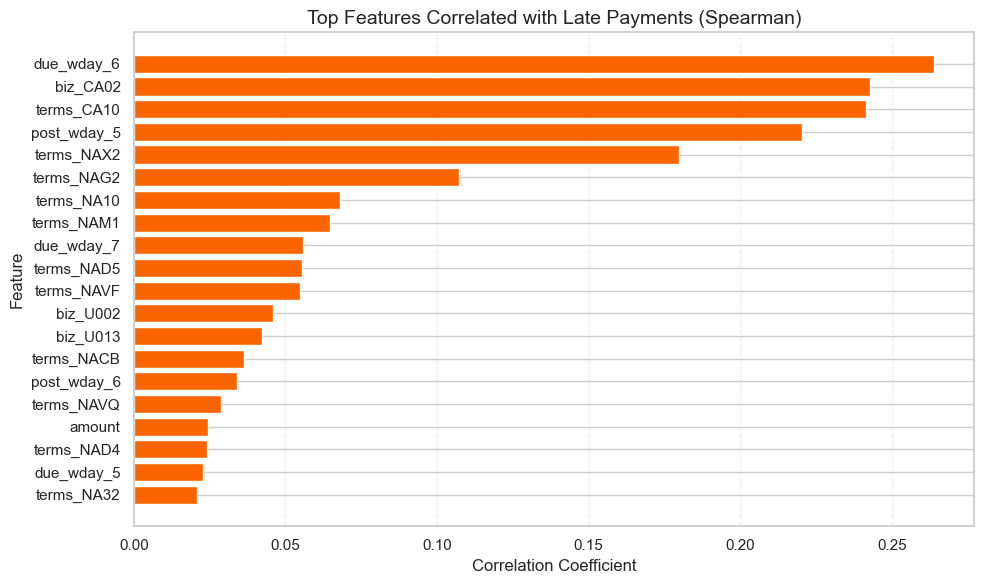

In [11]:
tr_orange = "#FA6400"
tr_green = "#123021"

# --- Calculate correlations ---
spearman_corr = feature_df_A.corr(method="spearman", numeric_only=True)
spearman_late = spearman_corr["is_late"].sort_values(ascending=False)

# Remove self-correlation and keep top 10
top10_late = spearman_late.drop(labels=["is_late"]).head(20)

# --- Plot ---
plt.figure(figsize=(10,6))

plt.barh(
    y=top10_late.index[::-1],   # reversed so highest is at top
    width=top10_late.values[::-1],
    color=tr_orange
)


plt.title("Top Features Correlated with Late Payments (Spearman)", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
print(closed_invoices.groupby("posting_weekday")["is_late"].mean())
print(closed_invoices.groupby("due_weekday")["is_late"].mean())

posting_weekday
1   0.2301
2   0.2232
3   0.2229
4   0.3083
5   0.5263
6   0.3467
7   0.2124
Name: is_late, dtype: float64
due_weekday
1   0.2525
2   0.2039
3   0.1779
4   0.1822
5   0.3236
6   0.5781
7   0.3684
Name: is_late, dtype: float64


In [13]:
#print(closed_invoices.groupby("business_code")["is_late"].mean())
#print(closed_invoices.groupby("cust_payment_terms")["is_late"].mean())

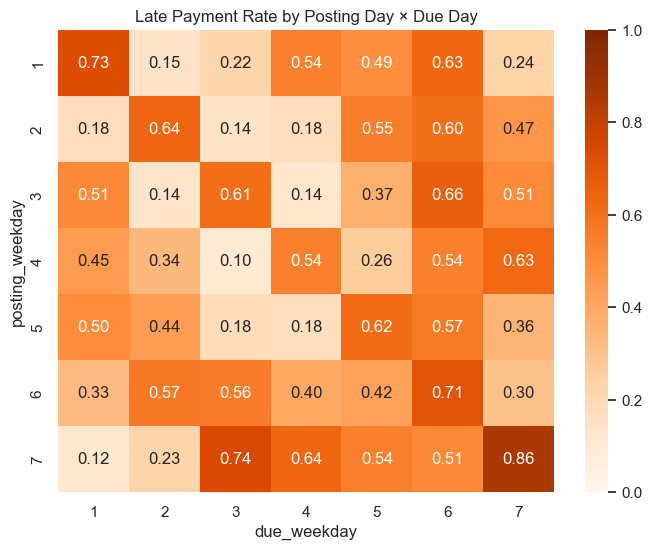

In [14]:
pivot = closed_invoices.pivot_table(
    values="is_late",
    index="posting_weekday",
    columns="due_weekday",
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    cmap="Oranges",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1
)
plt.title("Late Payment Rate by Posting Day × Due Day")
plt.show()


In [15]:
closed_invoices.groupby(["posting_weekday", "due_weekday"]).size().unstack()

due_weekday,1,2,3,4,5,6,7
posting_weekday,,,,,,,
1,206,4346,222,256,349,224,250
2,265,272,4903,254,285,443,221
3,288,310,234,5353,261,323,484
4,478,165,370,278,4723,237,304
5,334,275,114,279,388,4873,336
6,171,164,109,81,116,191,3050
7,2658,78,101,96,101,35,146


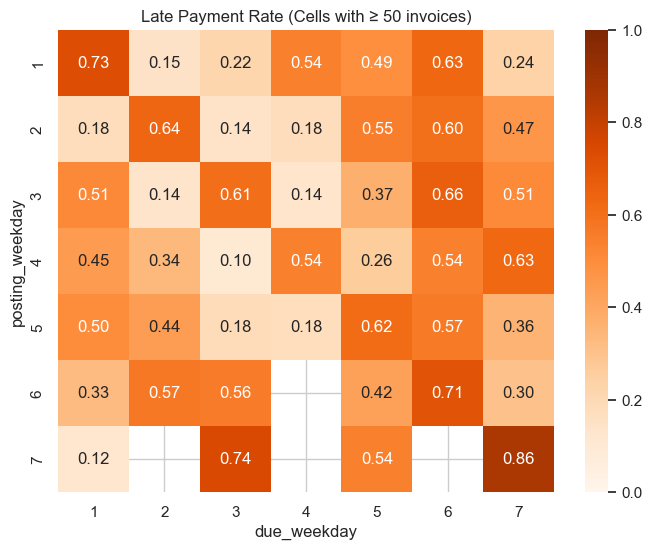

In [16]:
counts = closed_invoices.groupby(
    ["posting_weekday", "due_weekday"]
).size().unstack()

rates = closed_invoices.groupby(
    ["posting_weekday", "due_weekday"]
)["is_late"].mean().unstack()

mask = counts < 100

plt.figure(figsize=(8,6))
sns.heatmap(
    rates,
    mask=mask,
    cmap="Oranges",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1
)
plt.title("Late Payment Rate (Cells with ≥ 50 invoices)")
plt.show()


In [17]:
# Räkna förekomster av varje grace_period
gp_counts = closed_invoices["grace_period"].value_counts().sort_values(ascending=False)

# Beräkna procentandel
gp_pct = (gp_counts / gp_counts.sum() * 100).round(2)

# Slå ihop i en tabell
grace_summary = pd.DataFrame({
    "count": gp_counts,
    "pct": gp_pct
}).head(10)

print("Top 10 most common grace periods:")
display(grace_summary)


Top 10 most common grace periods:


,count,pct
grace_period,,
15,29719,74.3000
20,1060,2.6500
10,933,2.3300
11,877,2.1900
35,685,1.7100
65,643,1.6100
0,635,1.5900
32,607,1.5200
30,525,1.3100


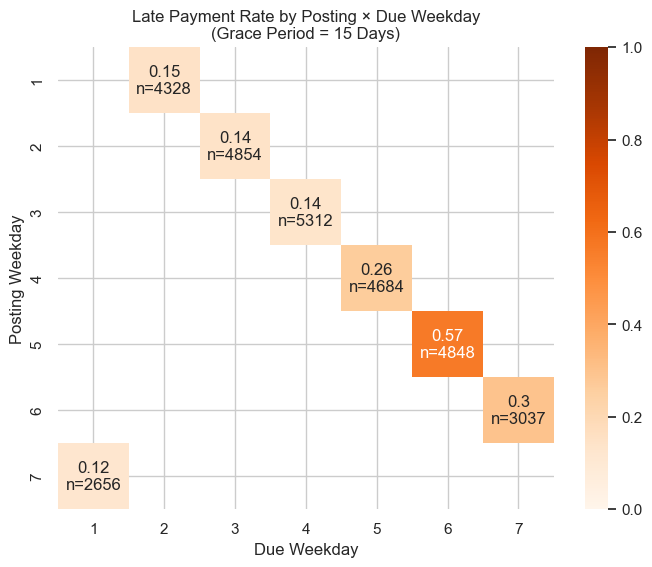

In [18]:
# Filtrera till endast grace_period = 15 dagar
gp15 = closed_invoices[closed_invoices["grace_period"] == 15].copy()

# Counts per cell
counts_15 = gp15.groupby(
    ["posting_weekday", "due_weekday"]
).size().unstack()

# Fyll NaN -> 0 och gör om till int
counts_15 = counts_15.fillna(0).astype(int)

# Lateness per cell
rates_15 = gp15.groupby(
    ["posting_weekday", "due_weekday"]
)["is_late"].mean().unstack()

# Kombinerad annotering: "0.57\nn=4873"
annot = rates_15.round(2).astype(str) + "\n" + "n=" + counts_15.astype(str)

plt.figure(figsize=(8,6))
sns.heatmap(
    rates_15,
    cmap="Oranges",
    annot=annot,
    fmt="",
    vmin=0,
    vmax=1
)
plt.title("Late Payment Rate by Posting × Due Weekday\n(Grace Period = 15 Days)")
plt.xlabel("Due Weekday")
plt.ylabel("Posting Weekday")
plt.show()


In [19]:
# Lägg till CA02-flagga på closed_invoices baserat på feature_df_A index
closed_invoices["biz_CA02"] = feature_df_A["biz_CA02"]

ca02 = closed_invoices[closed_invoices["biz_CA02"] == 1].copy()

ca02_total_amount = (
    ca02.groupby(["customer_alt_id", "customer_display_name"])["total_open_amount"]
    .sum()
    .reset_index(name="total_amount")
)

top10_ca02_amount = (
    ca02_total_amount
    .sort_values("total_amount", ascending=False)
    .head(10)
)

display(top10_ca02_amount)


,customer_alt_id,customer_display_name,total_amount
58,100405,lob co,"44,573,682.6500"
62,100409,so associates 100409,"28,497,016.3900"
120,100469,walm llc,"21,853,164.2800"
59,100406,metro llc,"16,113,772.0800"
60,100407,costco,"10,714,953.2800"
87,100435,sysc systems,"8,449,147.5600"
92,100441,gordon f corporation,"5,502,782.6400"
48,100395,feder co,"5,183,572.7900"
49,100396,sob corporation,"4,908,338.6600"
45,100392,saveon co,"3,696,879.4900"


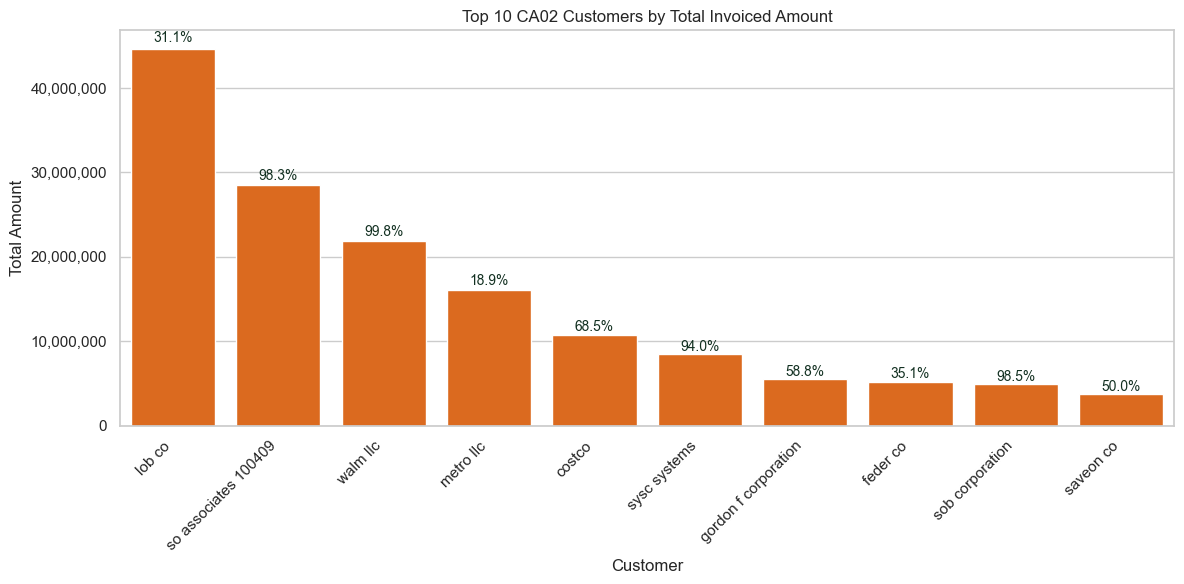

In [20]:
# 1. Filtrera till CA02-kunder baserat på feature_df_A
ca02_mask = feature_df_A["biz_CA02"] == 1
ca02_df = closed_invoices[ca02_mask].copy()

# 2. Beräkna total amount per kund
amount_stats = (
    ca02_df.groupby(["customer_alt_id", "customer_display_name"])["total_open_amount"]
    .sum()
    .reset_index()
    .rename(columns={"total_open_amount": "total_amount"})
)

# 3. Beräkna lateness per kund
late_rate = (
    ca02_df.groupby("customer_alt_id")["is_late"]
    .mean()
    .mul(100)
    .reset_index(name="pct_late")
)

# 4. Slå ihop
amount_stats = amount_stats.merge(late_rate, on="customer_alt_id")

# 5. Plocka topp 10
top10_amount_ca02 = (
    amount_stats.sort_values("total_amount", ascending=False)
    .head(10)
)

# 6. Plotta
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top10_amount_ca02,
    x="customer_display_name",
    y="total_amount",
    color=tr_orange
)

plt.title("Top 10 CA02 Customers by Total Invoiced Amount")
plt.xlabel("Customer")
plt.ylabel("Total Amount")
plt.xticks(rotation=45, ha="right")

# Formatera y-axeln till riktiga belopp (inte 1e7)
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ","))
)

# Lägg lateness rate som label
for bar, pct in zip(ax.patches, top10_amount_ca02["pct_late"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(
        x,
        y * 1.01,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#123021"
    )

plt.tight_layout()
plt.show()


In [21]:
# Hur många olika payment terms har varje kund?
terms_per_customer = (
    closed_invoices
    .groupby("customer_alt_id")["cust_payment_terms"]
    .nunique()
    .rename("unique_terms")
)

# Hur många kunder har 1,2,3... terms?
terms_distribution = terms_per_customer.value_counts().sort_index()

print("Number of unique payment terms per customer:")
display(terms_distribution)

# Visa kunder med mer än 1 term (om vi vill undersöka dem)
multi_term_customers = terms_per_customer[terms_per_customer > 1]
print(f"\nCustomers with >1 payment term: {len(multi_term_customers)}")
display(multi_term_customers.head(20))


Number of unique payment terms per customer:


unique_terms
1     829
2     105
3      84
4      25
5      11
6       1
11      1
Name: count, dtype: int64


Customers with >1 payment term: 227


customer_alt_id
100004    2
100011    2
100013    2
100019    2
100030    2
100040    2
100063    2
100068    2
100076    2
100085    2
100105    3
100112    2
100129    2
100132    4
100140    2
100183    2
100192    2
100202    2
100212    2
100267    2
Name: unique_terms, dtype: int64

/var/folders/mc/03k820yn1m36n8l072jj5ykc0000gn/T/ipykernel_1336/2408496168.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{x*100:.0f}%" for x in ax.get_yticks()])


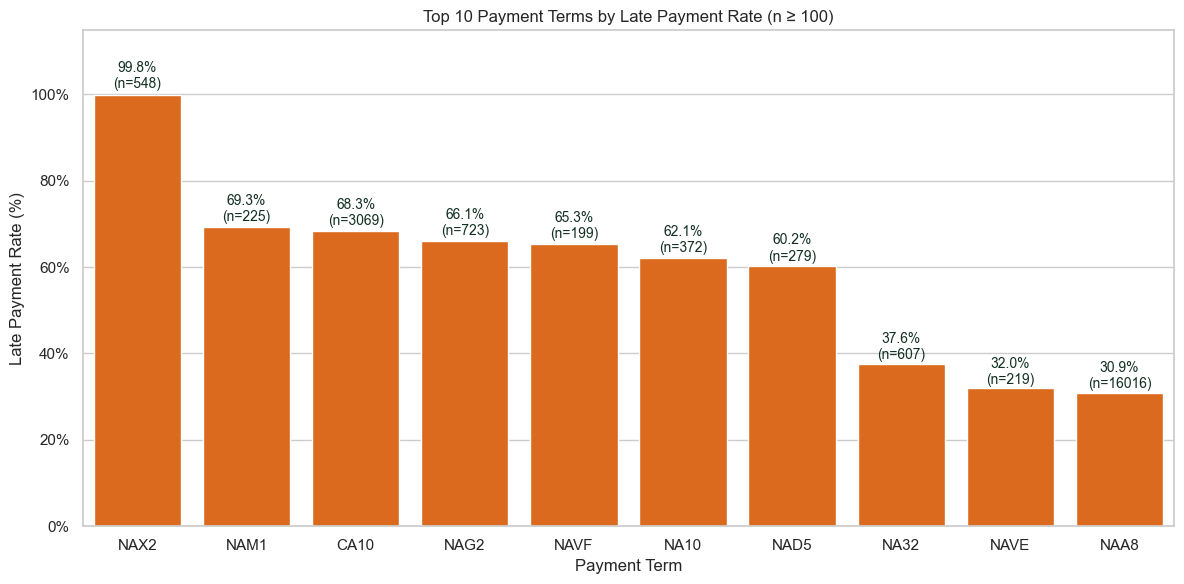

In [22]:
lateness_by_termcount = (
    closed_invoices
    .groupby(terms_per_customer)["is_late"]
    .mean() * 100
)

lateness_by_termcount

# Gruppnivå per payment term
term_stats = (
    closed_invoices
    .groupby("cust_payment_terms")
    .agg(
        lateness_rate=("is_late", "mean"),
        n_invoices=("invoice_id", "count")
    )
    .reset_index()
)

# Filtrera bort terms med låg volym
term_stats_filtered = term_stats[term_stats["n_invoices"] >= 100]

# Sortera efter lateness rate
top10_terms = (
    term_stats_filtered
    .sort_values("lateness_rate", ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top10_terms,
    x="cust_payment_terms",
    y="lateness_rate",
    color=tr_orange
)

plt.title("Top 10 Payment Terms by Late Payment Rate (n ≥ 100)")
plt.xlabel("Payment Term")
plt.ylabel("Late Payment Rate (%)")

ax.set_ylim(0, top10_terms["lateness_rate"].max() * 1.15)
ax.set_yticklabels([f"{x*100:.0f}%" for x in ax.get_yticks()])

# % + n label
for bar, (rate, n) in zip(ax.patches, zip(top10_terms["lateness_rate"], top10_terms["n_invoices"])):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    ax.text(
        x,
        y * 1.01,
        f"{rate*100:.1f}%\n(n={n})",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#123021"
    )

plt.tight_layout()
plt.show()


In [23]:
# Gruppstatistik per payment term
term_stats = (
    closed_invoices
    .groupby("cust_payment_terms")
    .agg(
        n_invoices=("invoice_id", "count"),
        avg_grace_period=("grace_period", "mean"),
        med_grace_period=("grace_period", "median"),
        lateness_rate=("is_late", "mean")
    )
    .reset_index()
)

# Filtrera bort terms med för få fakturor
term_stats_filtered = term_stats[term_stats["n_invoices"] >= 100].copy()

# Konvertera till procent
term_stats_filtered["lateness_rate"] = term_stats_filtered["lateness_rate"] * 100

# Sortera efter högst lateness
term_stats_filtered = term_stats_filtered.sort_values("lateness_rate", ascending=False)

display(term_stats_filtered)


,cust_payment_terms,n_invoices,avg_grace_period,med_grace_period,lateness_rate
69,NAX2,548,0.2427,0.0000,99.8175
36,NAM1,225,1.0267,1.0000,69.3333
5,CA10,3069,13.1828,12.0000,68.2602
33,NAG2,723,35.0609,35.0000,66.1134
60,NAVF,199,45.0000,45.0000,65.3266
11,NA10,372,10.0000,10.0000,62.0968
31,NAD5,279,29.5018,30.0000,60.2151
14,NA32,607,32.0000,32.0000,37.5618
59,NAVE,219,30.2009,30.0000,31.9635
21,NAA8,16016,14.9966,15.0000,30.9378


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# ---- Compute payment term stats (filtered for n >= 100) ----
term_stats = (
    closed_invoices
    .groupby("cust_payment_terms")
    .agg(
        lateness_rate=("is_late", lambda x: x.mean()*100),
        avg_grace_period=("grace_period", "mean"),
        n_invoices=("invoice_id", "count")
    )
)

# Filter out rare terms
term_stats = term_stats[term_stats["n_invoices"] >= 100].copy()

# Add log-volume
term_stats["log_n"] = np.log10(term_stats["n_invoices"])

# ---- Features for clustering ----
X = term_stats[["lateness_rate", "avg_grace_period", "log_n"]].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- K-means clustering ----
k = 3   # du kan ändra till 4 eller 5 senare
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

term_stats["cluster"] = labels
display(term_stats)


,lateness_rate,avg_grace_period,n_invoices,log_n,cluster
cust_payment_terms,,,,,
CA10,68.2602,13.1828,3069,3.4870,2
NA10,62.0968,10.0000,372,2.5705,1
NA32,37.5618,32.0000,607,2.7832,0
NAA8,30.9378,14.9966,16016,4.2046,2
NAAW,0.0000,34.0000,159,2.2014,0
NAAX,15.5925,15.0021,962,2.9832,0
NAC6,21.4123,15.0008,1317,3.1196,0
NAD1,16.3614,20.0012,819,2.9133,0
NAD5,60.2151,29.5018,279,2.4456,1


In [25]:
# Din profilfärg
tr_orange = "#FA6400"

# Färgpalett för kluster
cluster_palette = {
    0: "#123021",  # mörkgrön
    1: "#F5A623",  # gul/orange
    2: "#D0021B",  # röd
}

# Kopia med lite snyggare kolumner
df_terms = term_stats.copy()

# Sortera gärna på lateness %
df_terms = df_terms.sort_values("lateness_rate", ascending=False)


In [ ]:
# Skapa matris med tre “metrics”
cluster_map_df = df_terms.set_index("payment_term")[[
    "lateness_rate", "avg_grace_period", "invoice_count"
]].copy()

# Skala om lateness till %
cluster_map_df["lateness_rate"] = cluster_map_df["lateness_rate"] * 100

# Log-skalad volym för att synas bättre
cluster_map_df["invoice_count_log"] = np.log1p(cluster_map_df["invoice_count"])

# Välj vad vi faktiskt vill plota
heat_data = cluster_map_df[["lateness_rate", "avg_grace_period", "invoice_count_log"]]

plt.figure(figsize=(10, max(6, 0.4 * len(heat_data))))
sns.heatmap(
    heat_data,
    annot=True,
    fmt=".1f",
    cmap="Oranges",
    cbar_kws={"label": "Relative level"},
)
plt.title("Payment Terms – Cluster Map (Late %, Grace Period, Volume)")
plt.xlabel("Metric")
plt.ylabel("Payment Term")
plt.tight_layout()
plt.show()


NameError: name 'terms_cluster_stats' is not defined

ValueError: Could not interpret value `payment_term` for `y`. An entry with this name does not appear in `data`.

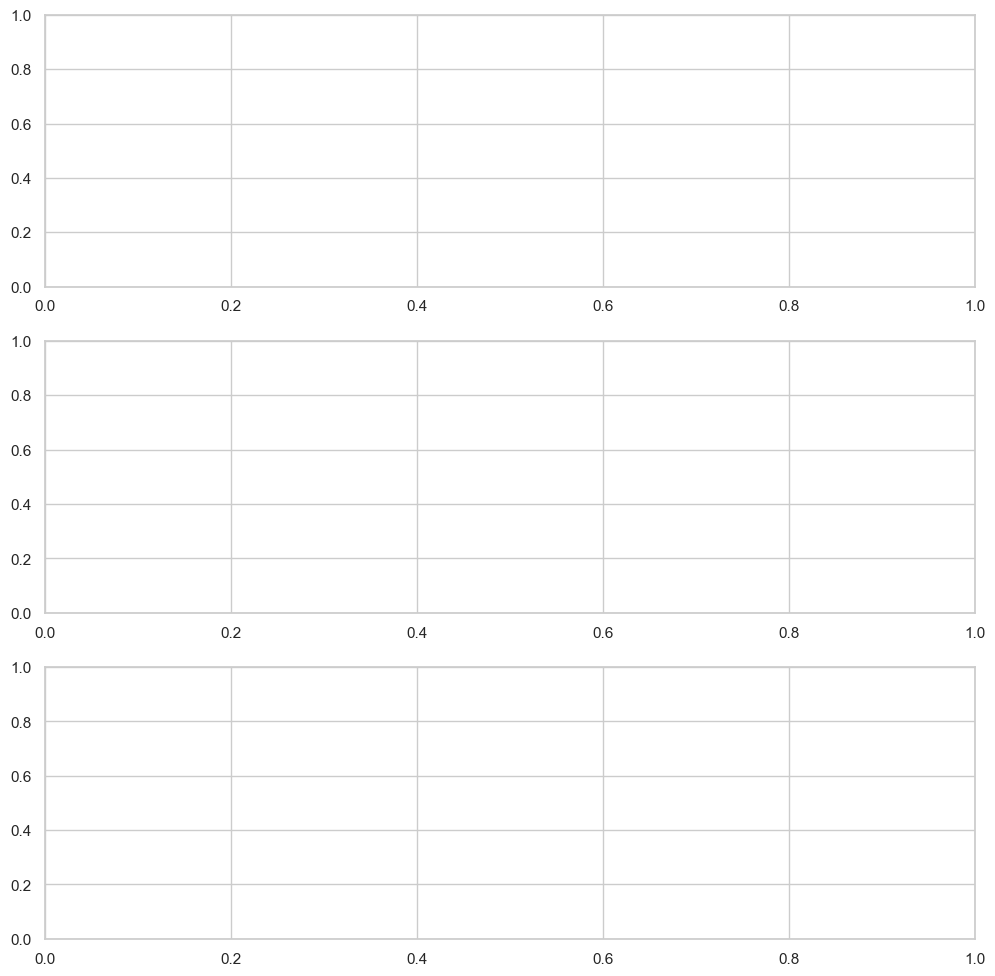

In [ ]:
clusters = sorted(df_terms["cluster"].unique())
n_clusters = len(clusters)

fig, axes = plt.subplots(
    n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=False
)

if n_clusters == 1:
    axes = [axes]

for ax, cl in zip(axes, clusters):
    sub = df_terms[df_terms["cluster"] == cl].copy()
    # sortera på lateness
    sub = sub.sort_values("lateness_rate", ascending=False)

    sns.barplot(
        data=sub,
        x="lateness_rate",
        y="payment_term",
        color=tr_orange,
        ax=ax,
    )

    # procent på x-axel
    ax.set_xlim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticklabels([f"{x*100:.0f}%" for x in ax.get_xticks()])
    ax.set_xlabel("Late Payment Rate (%)")
    ax.set_ylabel("Payment Term")
    ax.set_title(f"Cluster {cl} – Payment Terms")

    # labels på staplar (late% + n + grace)
    for i, row in sub.iterrows():
        ax.text(
            row["lateness_rate"] + 0.01,
            sub.index.get_loc(i),
            f"{row['lateness_rate']*100:.1f}%  |  n={int(row['invoice_count'])}  |  g={row['avg_grace_period']:.1f}d",
            va="center",
            fontsize=9,
            color="#123021",
        )

plt.tight_layout()
plt.show()


In [27]:
plt.figure(figsize=(10, 7))

for cl, group in df_terms.groupby("cluster"):
    plt.scatter(
        group["avg_grace_period"],
        group["lateness_rate"] * 100,
        s=20 + 3 * np.sqrt(group["invoice_count"]),  # bubbelstorlek ~ √n
        color=cluster_palette.get(cl, "grey"),
        alpha=0.7,
        label=f"Cluster {cl}",
        edgecolors="white",
        linewidths=0.5,
    )

# Lägg term-label på de viktigaste (t.ex. n >= 500 eller lateness > 0.5)
label_mask = (df_terms["invoice_count"] >= 500) | (df_terms["lateness_rate"] >= 0.5)
for _, row in df_terms[label_mask].iterrows():
    plt.text(
        row["avg_grace_period"],
        row["lateness_rate"] * 100,
        row["payment_term"],
        fontsize=9,
        ha="center",
        va="bottom",
    )

plt.xlabel("Average Grace Period (days)")
plt.ylabel("Late Payment Rate (%)")
plt.title("Payment Terms – Bubble Chart by Cluster")
plt.grid(alpha=0.2)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()


KeyError: 'invoice_count'

<Figure size 1000x700 with 0 Axes>

In [ ]:
from math import pi

# Aggregat per kluster
cluster_summary = (
    df_terms
    .groupby("cluster")
    .agg(
        lateness_rate=("lateness_rate", "mean"),
        avg_grace_period=("avg_grace_period", "mean"),
        volume=("invoice_count", "mean"),
    )
)

# Skala om lateness till %
cluster_summary["lateness_rate"] *= 100

# Normalisera volume till 0–100 för att passa radar
cluster_summary["volume_norm"] = (
    cluster_summary["volume"] / cluster_summary["volume"].max() * 100
)

metrics = ["lateness_rate", "avg_grace_period", "volume_norm"]
labels = ["Late %", "Grace (days)", "Volume (norm)"]
N = len(metrics)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # stäng polygonen

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for cl, row in cluster_summary.iterrows():
    values = [row[m] for m in metrics]
    values += values[:1]
    ax.plot(
        angles,
        values,
        color=cluster_palette.get(cl, "grey"),
        linewidth=2,
        label=f"Cluster {cl}",
    )
    ax.fill(
        angles,
        values,
        color=cluster_palette.get(cl, "grey"),
        alpha=0.15,
    )

# Axlar
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_rlabel_position(0)
ax.set_title("Radar Chart – Average Profile per Payment-Term Cluster", pad=20)

plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


KeyError: "Column(s) ['invoice_count'] do not exist"

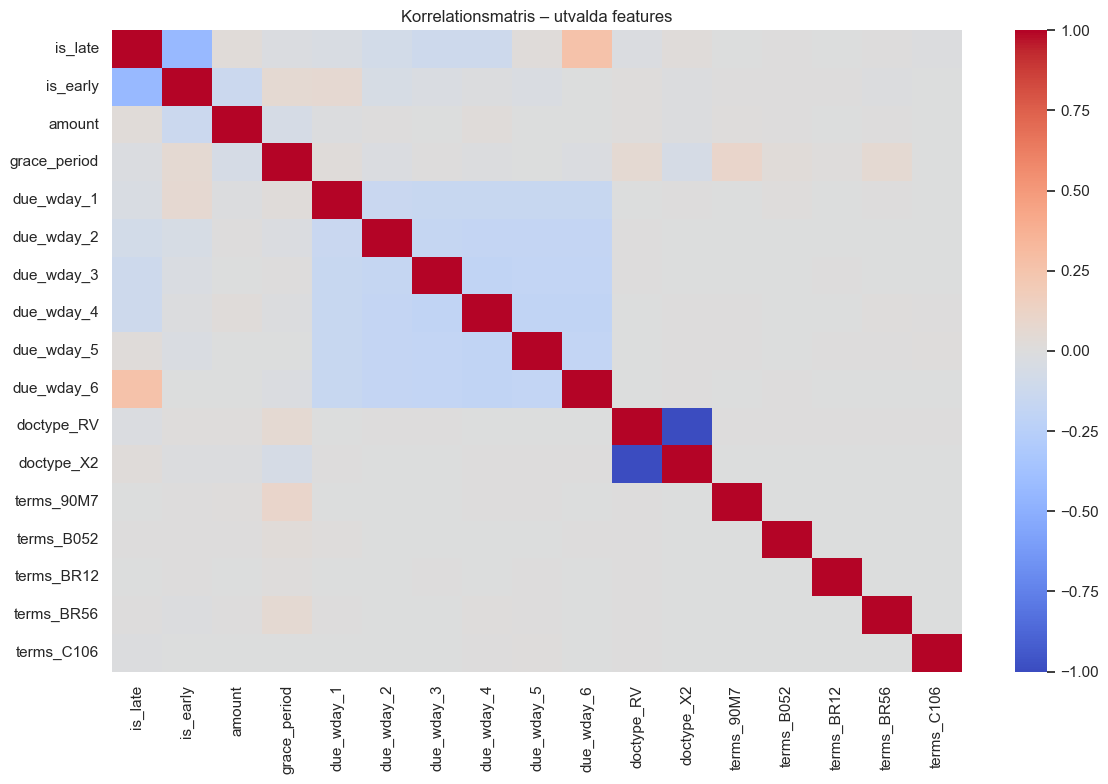

In [ ]:
# Basvariabler vi alltid vill ha med
base_cols = [
    "is_late",
    "is_early",
    "amount",
    "grace_period",
]

# Plocka ut några weekday-dummies (t.ex. alla för due & posting)
weekday_cols = [c for c in feature_df_A.columns if c.startswith("due_wday_") or c.startswith("post_wday_")]

# Begränsa antal för överskådlighet (valfritt)
weekday_cols = weekday_cols[:6]   # ta t.ex. de första 6

# Topp 5 dokumenttyper & payment terms (som tidigare)
doc_cols = list(document_type_dummies.columns[:5])
term_cols = list(payment_terms_dummies.columns[:5])

# Slå ihop alla kolumnnamn och filtrera på de som faktiskt finns i feature_df
cols_for_heatmap = [
    c for c in base_cols + weekday_cols + doc_cols + term_cols
    if c in feature_df_A.columns
]

corr_subset = feature_df_A[cols_for_heatmap].corr()

plt.figure(figsize=(max(12, 0.7*len(cols_for_heatmap)), 8))
sns.heatmap(
    corr_subset,
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Korrelationsmatris – utvalda features")
plt.tight_layout()
plt.show()


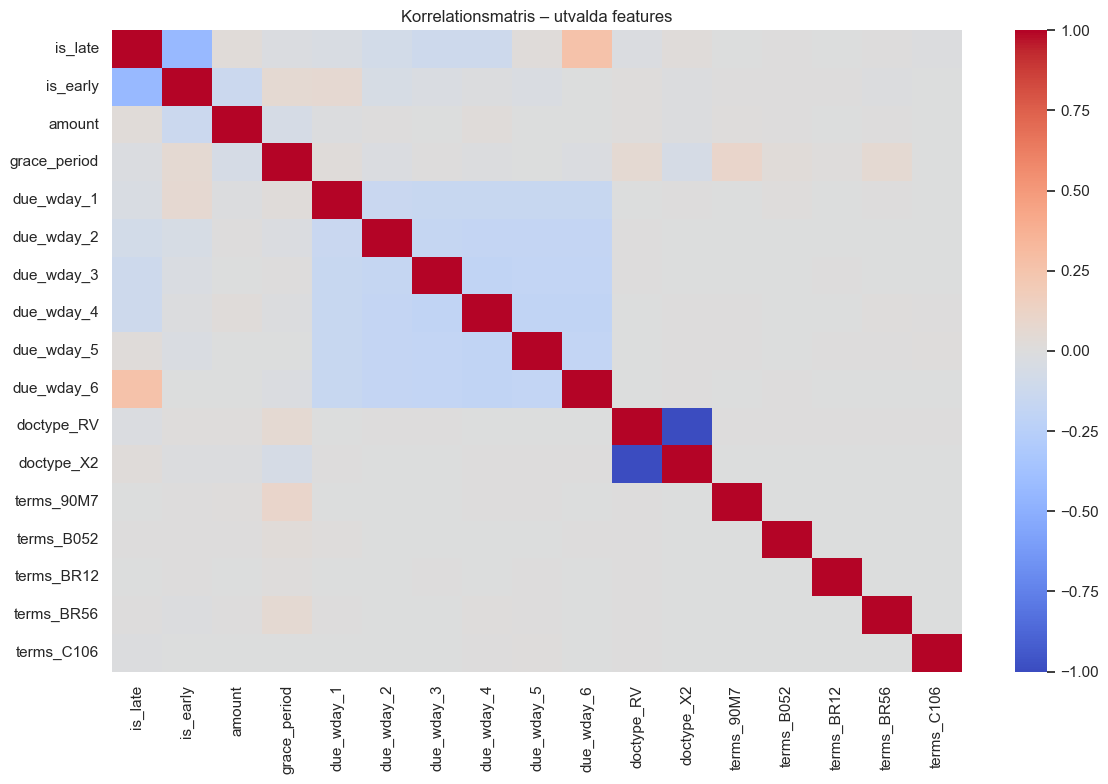

In [ ]:
# Basvariabler vi alltid vill ha med
base_cols = [
    "is_late",
    "is_early",
    "amount",
    "grace_period",
]

# Plocka ut några weekday-dummies (t.ex. alla för due & posting)
weekday_cols = [c for c in feature_df_A.columns if c.startswith("due_wday_") or c.startswith("post_wday_")]

# Begränsa antal för överskådlighet (valfritt)
weekday_cols = weekday_cols[:6]   # ta t.ex. de första 6

# Topp 5 dokumenttyper & payment terms (som tidigare)
doc_cols = list(document_type_dummies.columns[:5])
term_cols = list(payment_terms_dummies.columns[:5])

# Slå ihop alla kolumnnamn och filtrera på de som faktiskt finns i feature_df
cols_for_heatmap = [
    c for c in base_cols + weekday_cols + doc_cols + term_cols
    if c in feature_df_A.columns
]

corr_subset = feature_df_A[cols_for_heatmap].corr()

plt.figure(figsize=(max(12, 0.7*len(cols_for_heatmap)), 8))
sns.heatmap(
    corr_subset,
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Korrelationsmatris – utvalda features")
plt.tight_layout()
plt.show()


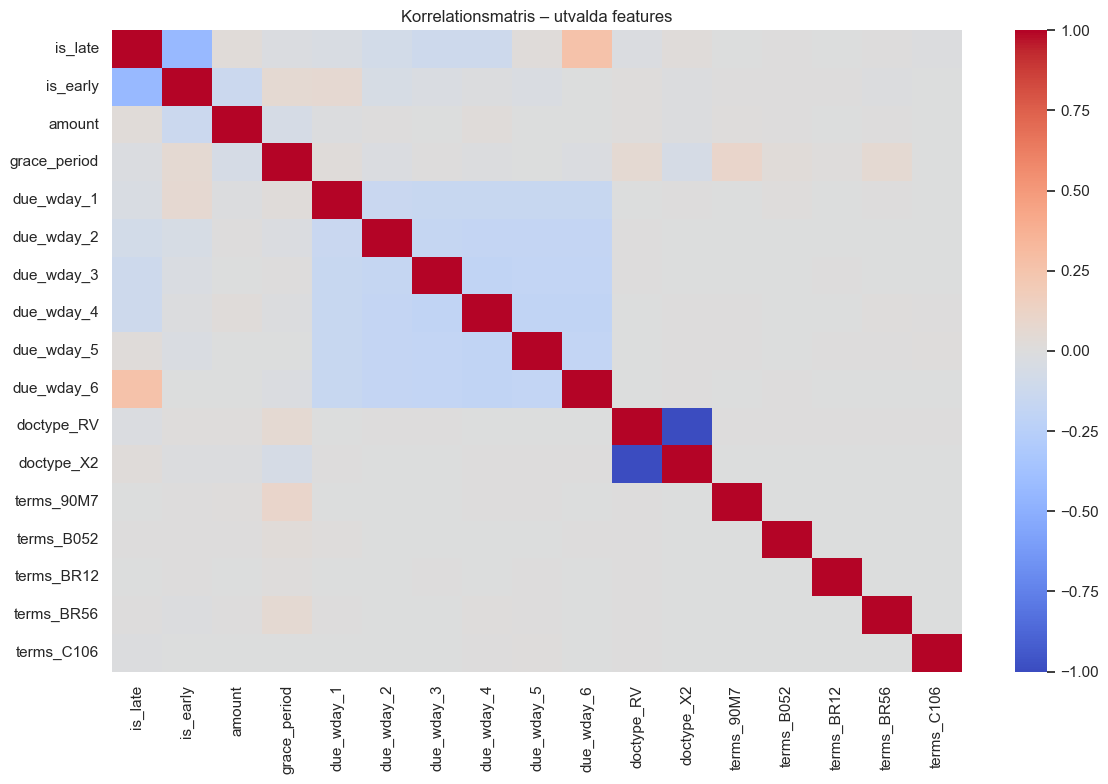

In [ ]:
# Basvariabler vi alltid vill ha med
base_cols = [
    "is_late",
    "is_early",
    "amount",
    "grace_period",
]

# Plocka ut några weekday-dummies (t.ex. alla för due & posting)
weekday_cols = [c for c in feature_df_A.columns if c.startswith("due_wday_") or c.startswith("post_wday_")]

# Begränsa antal för överskådlighet (valfritt)
weekday_cols = weekday_cols[:6]   # ta t.ex. de första 6

# Topp 5 dokumenttyper & payment terms (som tidigare)
doc_cols = list(document_type_dummies.columns[:5])
term_cols = list(payment_terms_dummies.columns[:5])

# Slå ihop alla kolumnnamn och filtrera på de som faktiskt finns i feature_df
cols_for_heatmap = [
    c for c in base_cols + weekday_cols + doc_cols + term_cols
    if c in feature_df_A.columns
]

corr_subset = feature_df_A[cols_for_heatmap].corr()

plt.figure(figsize=(max(12, 0.7*len(cols_for_heatmap)), 8))
sns.heatmap(
    corr_subset,
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Korrelationsmatris – utvalda features")
plt.tight_layout()
plt.show()


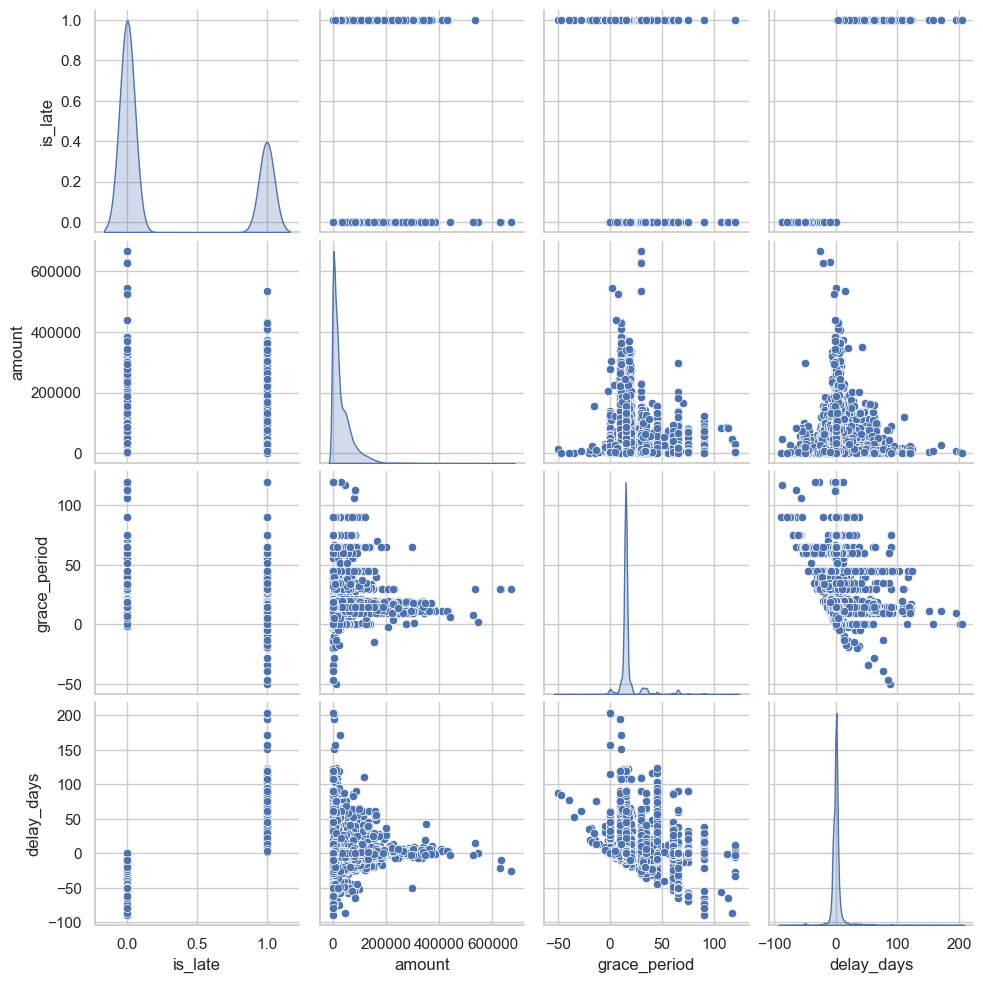

In [ ]:
# 2. Correlation Pairplot (endast utvalda features)
# Superkraftfullt för att hitta icke-linjära samband.

sns.pairplot(
    closed_invoices[["is_late", "amount", "grace_period", "delay_days"]],
    diag_kind="kde"
)
plt.show()


In [ ]:
# Correlation Table Sorted (Late vs Early)
# Visa bara features som har korrelation > threshold:

threshold = 0.1
corr_tbl = corr_with_late[abs(corr_with_late) > threshold]
corr_tbl


is_late        1.0000
due_wday_6     0.2639
biz_CA02       0.2427
terms_CA10     0.2416
post_wday_5    0.2204
terms_NAX2     0.1799
terms_NAG2     0.1072
terms_NAM4    -0.1095
due_wday_3    -0.1119
due_wday_4    -0.1136
terms_NAH4    -0.1923
biz_U001      -0.2495
is_early      -0.4323
Name: is_late, dtype: float64

In [ ]:
# Kundhistorik – måste köras innan base_features_B
customer_stats = (
    closed_invoices
    .groupby("customer_alt_id")
    .agg(
        cust_total_invoices=("invoice_id", "nunique"),
        cust_late_rate=("is_late", "mean"),
        cust_avg_delay=("delay_days", "mean"),
        cust_median_delay=("delay_days", "median"),
        cust_total_amount=("amount", "sum"),
        cust_avg_amount=("amount", "mean"),
        cust_avg_grace_period=("grace_period", "mean"),
    )
    .reset_index()
)

closed_invoices = closed_invoices.merge(
    customer_stats,
    on="customer_alt_id",
    how="left"
)
customer_feature_cols = [
    "cust_total_invoices",
    "cust_late_rate",
    "cust_avg_delay",
    "cust_median_delay",
    "cust_total_amount",
    "cust_avg_amount",
    "cust_avg_grace_period",
]

# Model B (Invoice + customer histories)
base_features_B = closed_invoices[
    ["is_late", "is_early", "amount", "grace_period"] + customer_feature_cols
]

feature_df_B = pd.concat(
    [
        base_features_B,
        document_type_dummies,
        payment_terms_dummies,
        business_code_dummies,
        due_weekday_dummies,
        posting_weekday_dummies,
    ],
    axis=1
)


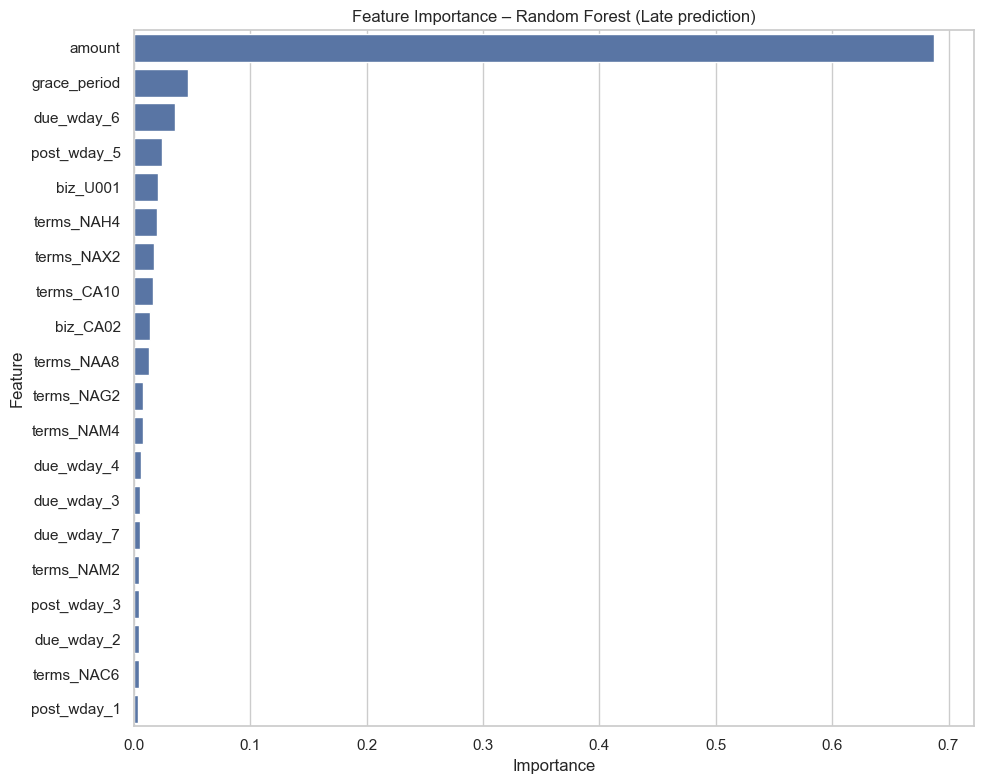

amount         0.6875
grace_period   0.0463
due_wday_6     0.0350
post_wday_5    0.0241
biz_U001       0.0208
terms_NAH4     0.0203
terms_NAX2     0.0174
terms_CA10     0.0162
biz_CA02       0.0141
terms_NAA8     0.0134
terms_NAG2     0.0081
terms_NAM4     0.0079
due_wday_4     0.0060
due_wday_3     0.0057
due_wday_7     0.0053
terms_NAM2     0.0049
post_wday_3    0.0043
due_wday_2     0.0042
terms_NAC6     0.0042
post_wday_1    0.0040
dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Feature matrix & target
X = feature_df_A.drop(columns=["is_late", "is_early"])
y = feature_df_A["is_late"]

# 2. Train/test-split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Train Random Forest
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 4. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# 5. Plot top 20 features
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index)
plt.title("Feature Importance – Random Forest (Late prediction)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 6. Visa toppvärden i tabell
top20


=== Modellprestanda ===
Accuracy:        0.7344
Precision:       0.5577
Recall:          0.5439
F1-score:        0.5507
ROC-AUC:         0.7622


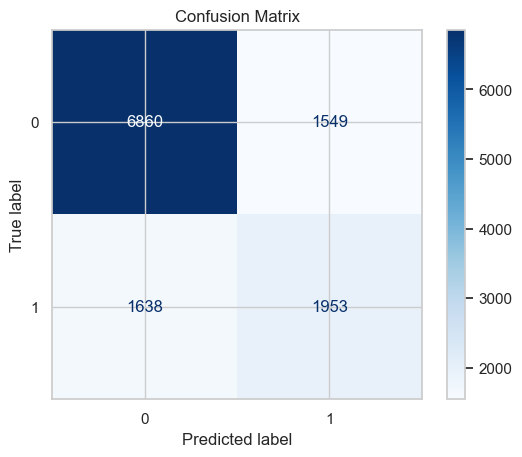

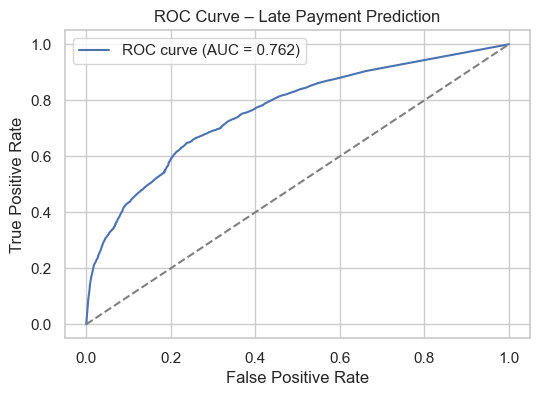

In [ ]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# -------------------------------
# 1. Dataset (som du har byggt)
# -------------------------------
X = feature_df_A.drop(columns=["is_late", "is_early"])
y = feature_df_A["is_late"]

# -------------------------------
# 2. Train/Test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# 3. Träna modellen
# -------------------------------
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# -------------------------------
# 4. Prediktioner
# -------------------------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# -------------------------------
# 5. Grundläggande mått
# -------------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Modellprestanda ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1-score:        {f1:.4f}")
print(f"ROC-AUC:         {auc:.4f}")

# -------------------------------
# 6. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# 7. ROC Curve
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Late Payment Prediction")
plt.legend()
plt.show()


In [ ]:
# ROC curve ger fpr, tpr och thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Youden's J-statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"Sensitivity (TPR): {tpr[optimal_idx]:.4f}")
print(f"Specificity (1-FPR): {1 - fpr[optimal_idx]:.4f}")

# Testa modellen med optimal threshold
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

acc_opt = accuracy_score(y_test, y_pred_opt)
prec_opt = precision_score(y_test, y_pred_opt)
rec_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

print("\n=== Prestanda vid optimal threshold ===")
print(f"Accuracy:  {acc_opt:.4f}")
print(f"Precision: {prec_opt:.4f}")
print(f"Recall:    {rec_opt:.4f}")
print(f"F1-score:  {f1_opt:.4f}")


Optimal threshold (Youden's J): 0.2733
Sensitivity (TPR): 0.6477
Specificity (1-FPR): 0.7620

=== Prestanda vid optimal threshold ===
Accuracy:  0.7278
Precision: 0.5376
Recall:    0.6477
F1-score:  0.5875


In [ ]:
X_A = feature_df_A.drop(columns=["is_late", "is_early"])
y_A = feature_df_A["is_late"]

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y_A, test_size=0.3, random_state=42
)

model_A = RandomForestClassifier(n_estimators=300, random_state=42)
model_A.fit(X_train_A, y_train_A)

y_pred_A = model_A.predict(X_test_A)
y_proba_A = model_A.predict_proba(X_test_A)[:, 1]


In [ ]:
# 1. Ta bort rader där is_late saknas
feature_df_B_clean = feature_df_B[feature_df_B["is_late"].notna()].copy()

# 2. Bygg X_B och y_B från den rensade versionen
X_B = feature_df_B_clean.drop(columns=["is_late", "is_early"])
y_B = feature_df_B_clean["is_late"].astype(int)

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, test_size=0.3, random_state=42
)

model_B = RandomForestClassifier(n_estimators=300, random_state=42)
model_B.fit(X_train_B, y_train_B)

y_pred_B = model_B.predict(X_test_B)
y_proba_B = model_B.predict_proba(X_test_B)[:, 1]


In [ ]:
def evaluate_model(name, y_test, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")

# Utvärdera båda
evaluate_model("Model A – Invoice only", y_test_A, y_pred_A, y_proba_A)
evaluate_model("Model B – Invoice + Customer history", y_test_B, y_pred_B, y_proba_B)



=== Model A – Invoice only ===
Accuracy:  0.7316
Precision: 0.5564
Recall:    0.5387
F1-score:  0.5474
ROC-AUC:   0.7636

=== Model B – Invoice + Customer history ===
Accuracy:  0.7353
Precision: 0.5699
Recall:    0.4961
F1-score:  0.5305
ROC-AUC:   0.7596


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import numpy as np

# =====================================================
# Model B – Invoice + kausal kundhistorik (laggade features)
# =====================================================

# 1. Sortera per kund och datum (så att historiken blir kausal)
closed_sorted = closed_invoices.sort_values(
    ["customer_alt_id", "posting_date"]
).copy()

# 2. Laggade kundfeatures (endast historik upp till t-1)

# antal tidigare fakturor
closed_sorted["cust_total_invoices_lag"] = (
    closed_sorted.groupby("customer_alt_id").cumcount()
)

# sen-rate fram till t-1
closed_sorted["cust_late_rate_lag"] = (
    closed_sorted
    .groupby("customer_alt_id")["is_late"]
    .apply(lambda x: x.shift().expanding().mean())
)

# genomsnittlig försening fram till t-1
closed_sorted["cust_avg_delay_lag"] = (
    closed_sorted
    .groupby("customer_alt_id")["delay_days"]
    .apply(lambda x: x.shift().expanding().mean())
)

# medianförsening fram till t-1
closed_sorted["cust_median_delay_lag"] = (
    closed_sorted
    .groupby("customer_alt_id")["delay_days"]
    .apply(lambda x: x.shift().expanding().median())
)

# genomsnittlig grace_period fram till t-1
closed_sorted["cust_avg_grace_period_lag"] = (
    closed_sorted
    .groupby("customer_alt_id")["grace_period"]
    .apply(lambda x: x.shift().expanding().mean())
)

# 3. Bygg base_features_B med både faktura- och kundhistorik-features
customer_feature_cols = [
    "cust_total_invoices_lag",
    "cust_late_rate_lag",
    "cust_avg_delay_lag",
    "cust_median_delay_lag",
    "cust_avg_grace_period_lag",
]

base_features_B = closed_sorted[
    ["is_late", "is_early", "amount", "grace_period"] + customer_feature_cols
]

# 4. Slå ihop med dummies till feature_df_B
feature_df_B = pd.concat(
    [
        base_features_B,
        document_type_dummies.reindex(closed_sorted.index),
        payment_terms_dummies.reindex(closed_sorted.index),
        business_code_dummies.reindex(closed_sorted.index),
        due_weekday_dummies.reindex(closed_sorted.index),
        posting_weekday_dummies.reindex(closed_sorted.index),
    ],
    axis=1
)

# 5. Rensa bort rader där target eller laggade features saknas
cols_must_have = ["is_late"] + customer_feature_cols
feature_df_B_clean = feature_df_B.dropna(subset=cols_must_have).copy()

print("Rader före rensning:", len(feature_df_B))
print("Rader efter rensning:", len(feature_df_B_clean))

# 6. Bygg X_B och y_B
X_B = feature_df_B_clean.drop(columns=["is_late", "is_early"])
y_B = feature_df_B_clean["is_late"].astype(int)

# 7. Train/test-split
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, test_size=0.3, random_state=42, stratify=y_B
)

# 8. Träna Random Forest
model_B = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model_B.fit(X_train_B, y_train_B)

# 9. Prediktioner och prestanda
y_pred_B = model_B.predict(X_test_B)
y_proba_B = model_B.predict_proba(X_test_B)[:, 1]

acc_B = accuracy_score(y_test_B, y_pred_B)
prec_B = precision_score(y_test_B, y_pred_B)
rec_B = recall_score(y_test_B, y_pred_B)
f1_B = f1_score(y_test_B, y_pred_B)
auc_B = roc_auc_score(y_test_B, y_proba_B)

print("\n=== Model B – Invoice + Kausal kundhistorik (laggade features) ===")
print(f"Accuracy:  {acc_B:.4f}")
print(f"Precision: {prec_B:.4f}")
print(f"Recall:    {rec_B:.4f}")
print(f"F1-score:  {f1_B:.4f}")
print(f"ROC-AUC:   {auc_B:.4f}")


TypeError: incompatible index of inserted column with frame index